### Exploring Number of Zeemans Measurements
This notebook uses a synthetic polarization map, with some (user-defined) number of Zeeman measurements, to reconstruct the magnetic field. It then explores the number of Zeeman measurements needed to converge on the known geometry. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import data_gen as dg
import recon_funcs as rf
import Sampler as sampler 
import more_functions as mf

In [ ]:
def zeeman_recon_min_2D(u, plotting, near_neighbor):
    # U, Q, COS2G, BLOS, plotting
    U     = u[0]
    Q     = u[1]
    COS2G = u[2]
    BLOS  = u[3]

    nx, ny = U.shape[0], U.shape[1]

    plt.imshow(BLOS, origin="lower", cmap="viridis")
    print('num. of BLOS values', len(np.where(BLOS != -1)))
    print('SHAPE BLOS', np.shape(BLOS), 'SHAPE U', np.shape(U))

    # First, check to see if we have any BLOS values at all
    num_BLOS_values = len(np.where(BLOS != -1)[0])
    if num_BLOS_values == 0:
        print('No BLOS values found, performing pure polarimetric reconstruction')
        bx, by, bz = mf.precon(U, Q, COS2G, array_input=True)
    
    else:
        

        # if near_neighbor is True, we will fill in missing BLOS values with nearest neighbor
        if near_neighbor == True:
            new_BLOS = np.zeros((nx, ny))
            # For levels larger than 1 cell
            if BLOS.shape[0] > 1:
                for i in range(nx):
                    for j in range(ny):
                        # For each cell, find nearest BLOS value that isn't -1, assign to new_BLOS array
                        # so that each cell has some BLOS value. 
                        index = mf.nearest_non_minus_one(BLOS, (i,j), allow_diagonals=False)
                        new_BLOS[i,j] = BLOS[index]
            # 1 cell lvl
            else:
                new_BLOS = BLOS
            # Reconstruct Bx, By, Bz with new BLOS array
            print('BLOS values found, performing Zeeman + polarimetric reconstruction')
            bx, by, bz = mf.zrecon(U, Q, new_BLOS, COS2G)
        
        # If near_neighbor is False, only reconstruct where we have BLOS values. Otherwise, use polarimetric only.
        if near_neighbor == False:
            bx = np.zeros((nx,ny))
            by = np.zeros((nx,ny))
            bz = np.zeros((nx,ny))
            # For levels larger than 1 cell
            if BLOS.shape[0] > 1:
                # have to step thru each cell, and reconstruct based on BLOS information available
                for i in range(nx):
                    for j in range(ny):
                        if BLOS[i][j] != -1:
                            # print('BLOS values found, performing Zeeman + polarimetric reconstruction')
                            BX, BY, BZ = mf.zrecon(U[i][j], Q[i][j], BLOS[i][j], COS2G[i][j])
                            bx[i][j] = BX
                            by[i][j] = BY
                            bz[i][j] = BZ
                        else:
                            # print('No BLOS values found, performing pure polarimetric reconstruction')
                            BX, BY, BZ = mf.precon(U[i][j], Q[i][j], COS2G[i][j], array_input=False)
                            bx[i][j] = BX
                            by[i][j] = BY
                            bz[i][j] = BZ

    # Diagnostics / plotting
    if plotting == 1:
        fig, ax = plt.subplots(1, 4, figsize=(22,4))

        im0 = ax[0].imshow(bx, origin="lower", cmap="RdBu")
        ax[0].set_title("Bx map")
        plt.colorbar(im0, ax=ax[0],fraction=0.046, pad=0.04)

        im1 = ax[1].imshow(by, origin="lower", cmap="RdBu")
        ax[1].set_title("By map")
        plt.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)

        im2 = ax[2].imshow(bz, origin="lower", cmap="RdBu")
        ax[2].set_title("Bz map (Zeeman)")
        plt.colorbar(im2, ax=ax[2],fraction=0.046, pad=0.04)

        # Quiver plot: POS field vectors
        step = 1   # downsample arrows
        ax[3].imshow(bz, origin="lower", cmap="viridis")
        i = np.arange(0, nx, step)
        j = np.arange(0, ny, step)
        ax[3].quiver(j, i, by[::step, ::step],bx[::step, ::step],
                    color="red", headaxislength=0, headlength=0, headwidth=1, pivot='middle')
        ax[3].set_title("POS field (bx, by)")

        plt.tight_layout()
        plt.show()
    
    return [bx,by,bz]

In [ ]:
def p_vcycle(u1_list, b3_list, J, C): # u1_list restricted 2d DATA (U, Q, cos2g), b3_list is the prolonged layers, J is the level we're on

    if len(u1_list) != 0: 

        if J == 1: # this is for the first cell only, where u11 = u21, and skips sampling
            
            u11 = u1_list.pop() # restricted layers, act as data
            
            b11 = zeeman_recon_min_2D(u11, plotting=1, near_neighbor=False) # Reconstruct restricted 1x1 square into cube
        
            b3_list.append(b11) # save 2x2x2 cube
            
            J = b11[0][0].shape[0]

            print(J)

            p_vcycle(u1_list, b3_list, J, C)

        else:            
            u12 = u1_list.pop() # restricted 2d DATA; every time a level is used, remove
            
            b12 = zeeman_recon_min_2D(u12, plotting=1, near_neighbor=False) # reconstruct nxn square into nxnxn cube

            b3_list.append(b12)
                                    
            if u12[0][0].shape[0] < C:  # still growing, still prolongating

                J = b12[0][0].shape[0]

                p_vcycle(u1_list, b3_list, J, C)

            elif u12[0][0].shape[0] == C: # Hit last level. No more prolongation, but still want to sample 
                print('Ceiling Hit at J = ', u12[0][0].shape[0])
                return
            else:
                print('You have gone past input dimensions, something is wrong.')
    else:
        print('All levels reached, returning...') # once on last level, return


In [5]:
def r_vcycle(tdmap, u1_list, b3_list, C):
    J = tdmap[0][0].shape[0]
    if J == 1: # check size is 1 cell
        # print('[checkpoint]: check for list of restricted layers')
        print('lvl == 1: Bottom reached; Begin Prolongation')
        p_vcycle(u1_list, b3_list, J, C) # start prolongation cycle at smallest cell

    else:
        u0 = rf.restrict_zeeman_min(tdmap) # restrict to lower resolution
        print('shape:',np.shape(u0[0]), np.shape(u0[3]))
        u1_list.append(u0) # save each restricted 2D level
        r_vcycle(u0, u1_list, b3_list, C) # restart cycle for next lvl
    

## Multigrid()

In [6]:
def multigrid(u): # takes in 2D array of data, and number of runs for sampler
    C    = u[0][0].shape[0]
    print('Ceiling = ', C)
    if (C % 2 == 0):
        u1_list = [] # restricted
        b2_list = [] # sampled
        b3_list = [] # prolonged

        u1_list.append(u) # save first level

        r_vcycle(u, u1_list, b3_list, C) # u = data, u0 enters with saved data array, u1 enters empty.
        print('[Multigrid]: Complete.')
            
    else:
        print('[Multigrid]: J must be even: C=%4i' % (C))

    return b3_list    

## RUN

In [7]:
print('===============')
print('Loading data...')
# U, Q, COS, B_los_map, Bx, By, Bz = dg.wavy_zeeman_pol_min(box_length=32,amplitude=1.2,frequency=1,x_const=0.2,num_measurements=4,plotting=1)
# U, Q, COS, B_los_map, Bx, By, Bz = dg.wavy_zeeman_pol_min_vary(box_length=16,amplitude=1.2,frequency=1,z_vals=[0.25,0.5,0.75,1],num_measurements=4,plotting=1)
U, Q, COS, B_los_map, Bx, By, Bz = dg.wavy_zeeman_pol_min_vary(box_length=16,amplitude=1.2,frequency=1,z_vals=[1,2,3,4],nz=10,plotting=0)

UQpol_array = [U, Q, COS, B_los_map]

# plt.imshow(COS, origin="lower", cmap ='RdBu')
# plt.colorbar()

Loading data...


Reconstructing in 3 Dimensions
Ceiling =  16
Restricting... Level =  16
shape: (8, 8) (8, 8)
Restricting... Level =  8
shape: (4, 4) (4, 4)
Restricting... Level =  4
shape: (2, 2) (2, 2)
Restricting... Level =  2
shape: (1, 1) (1, 1)
lvl == 1: Bottom reached; Begin Prolongation
num. of BLOS values 2
SHAPE BLOS (1, 1) SHAPE U (1, 1)


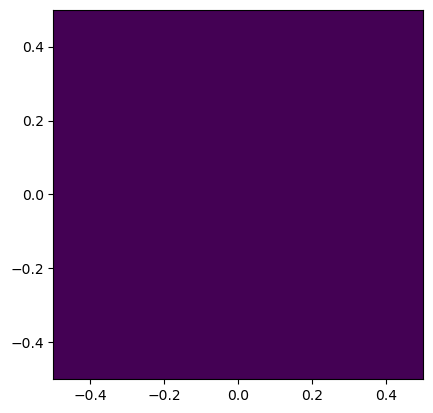

/Users/sophiakressy/miniconda3/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/sophiakressy/miniconda3/lib/python3.12/site-packages/matplotlib/quiver.py:695: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


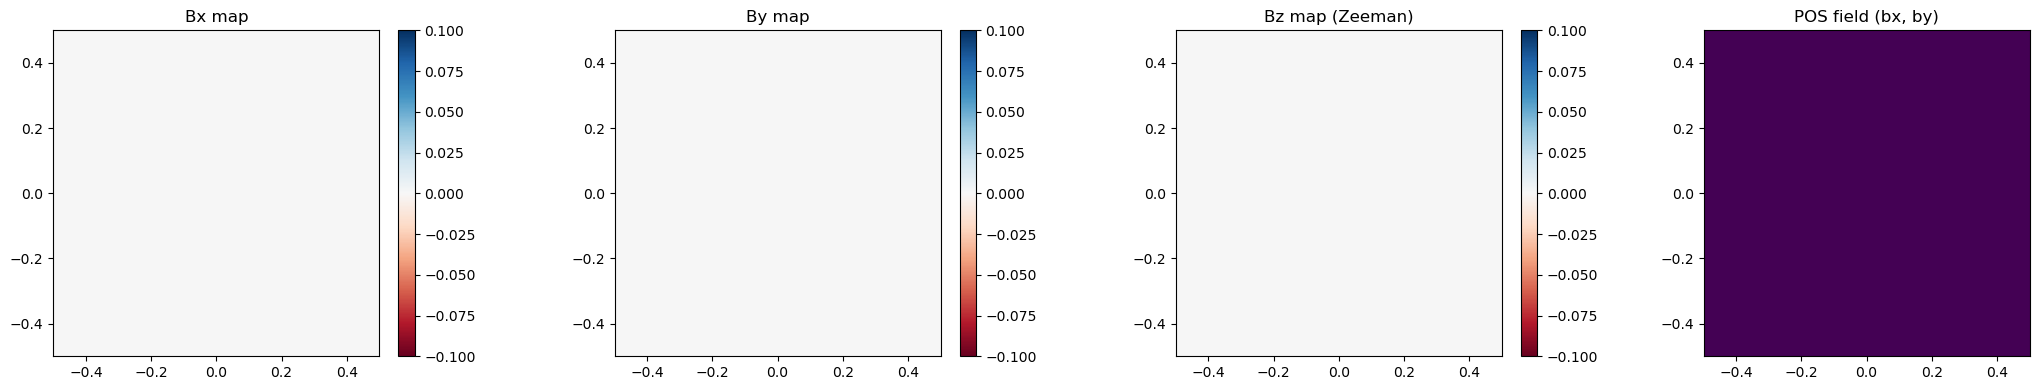

1
num. of BLOS values 2
SHAPE BLOS (2, 2) SHAPE U (2, 2)
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction


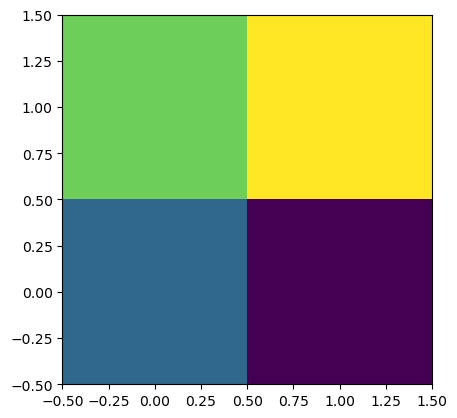

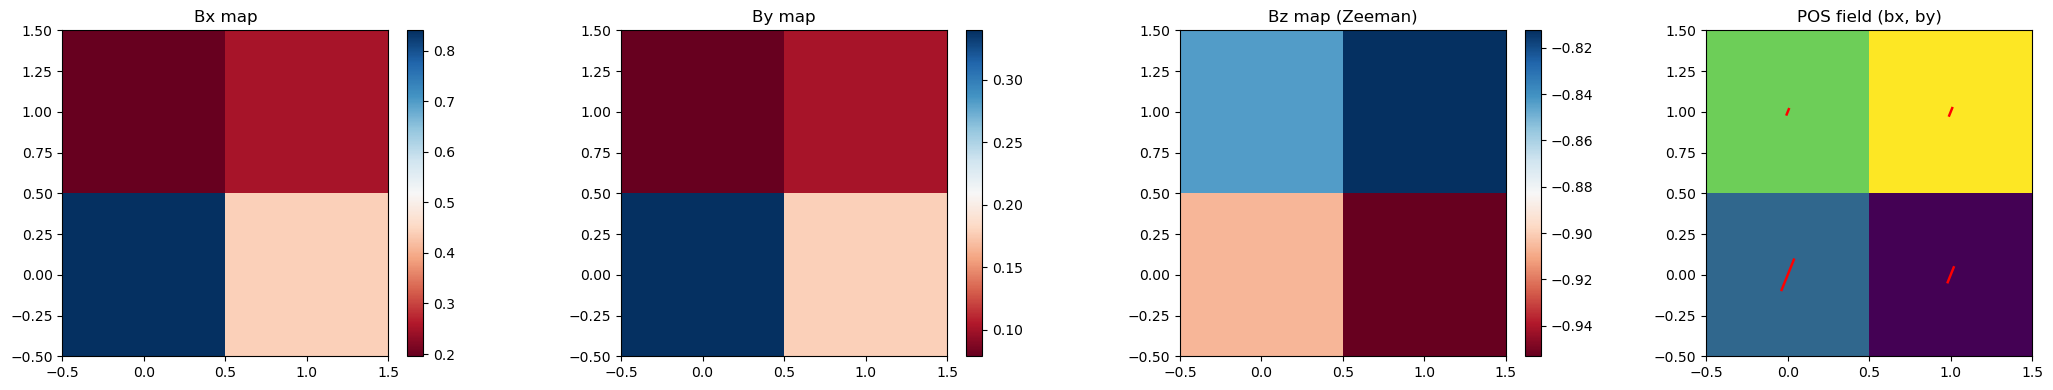

2
num. of BLOS values 2
SHAPE BLOS (4, 4) SHAPE U (4, 4)
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS val

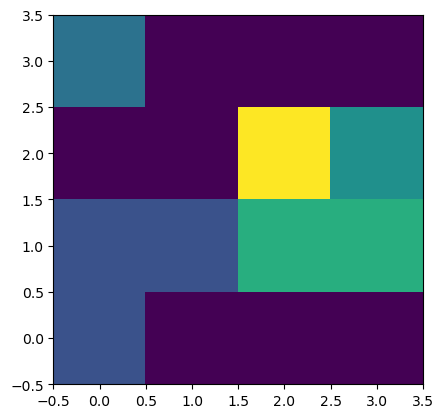

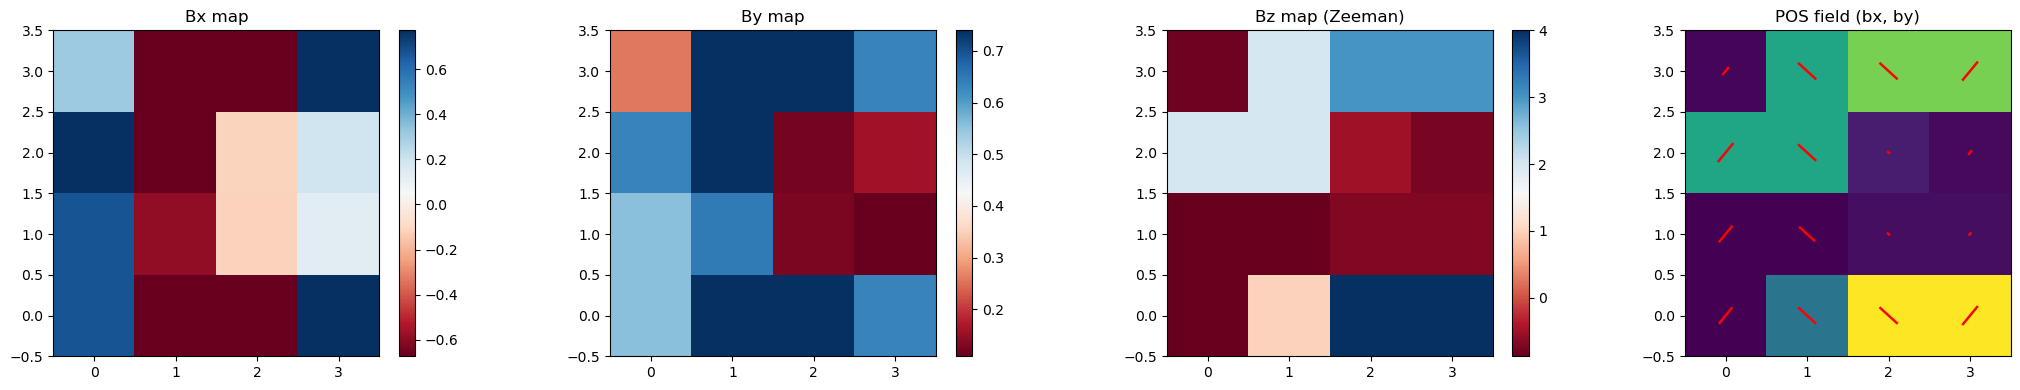

SHAPE (3, 4, 4)
num. of BLOS values 2
SHAPE BLOS (8, 8) SHAPE U (8, 8)
No BLOS values found, performing pure polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
BLOS values found, performing Zeeman + polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No

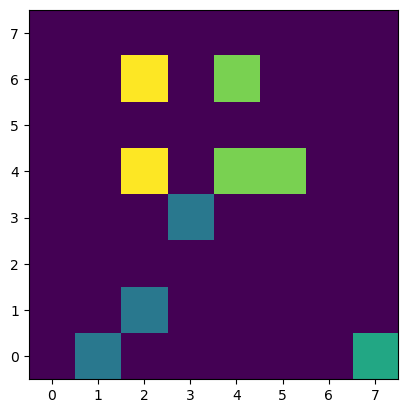

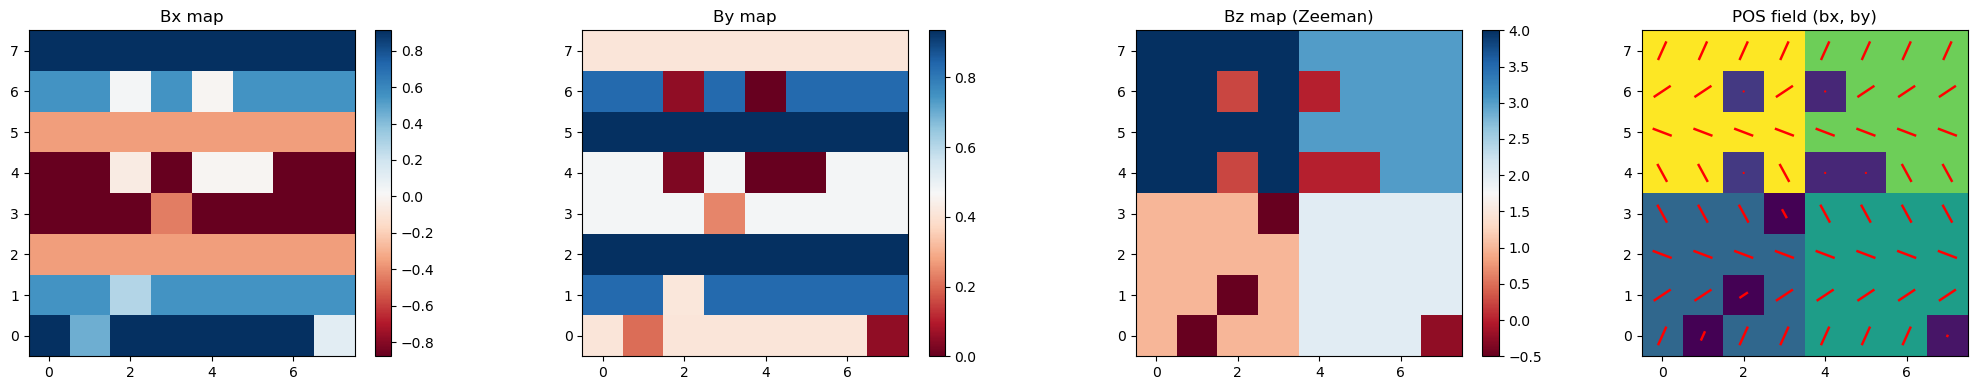

SHAPE (3, 8, 8)
num. of BLOS values 2
SHAPE BLOS (16, 16) SHAPE U (16, 16)
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
No BLOS values found, performing pure polarimetric reconstruction
N

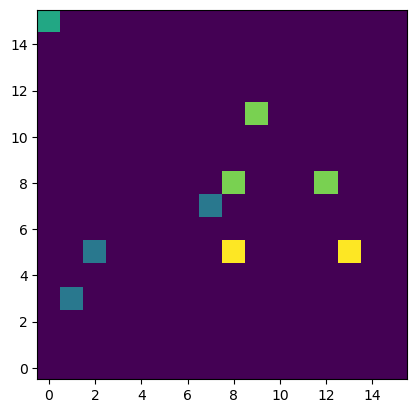

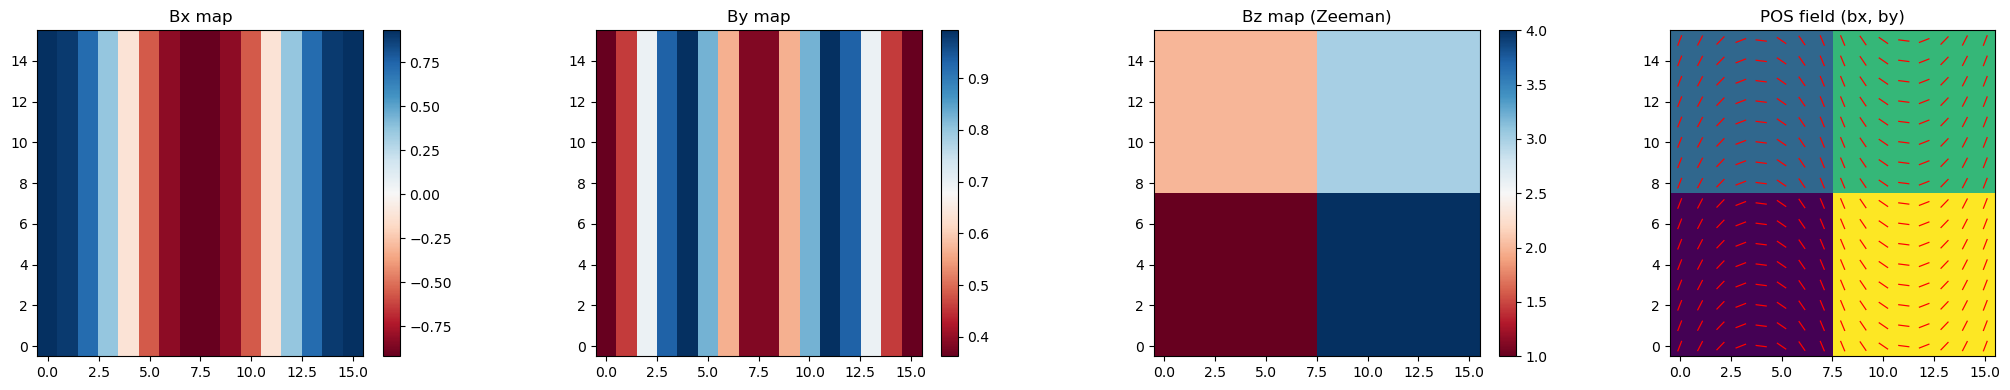

SHAPE (3, 16, 16)
Ceiling Hit at J =  16
[Multigrid]: Complete.


In [8]:
print('Reconstructing in 3 Dimensions')
d3_field = multigrid(UQpol_array)


In [9]:
print(len(d3_field))
print(np.shape(d3_field[4]))

5
(3, 16, 16)


## create Stokes U/Q/Cos2G to compare

In [10]:
bxr = d3_field[4][0]
byr = d3_field[4][1]
bzr = d3_field[4][2]

icos2g  = (bxr**2+byr**2)/(bxr**2+byr**2+bzr**2)
iq      = (byr**2-bxr**2)/(bxr**2+byr**2) * icos2g
iu      = 2*bxr*byr/(bxr**2+byr**2) * icos2g



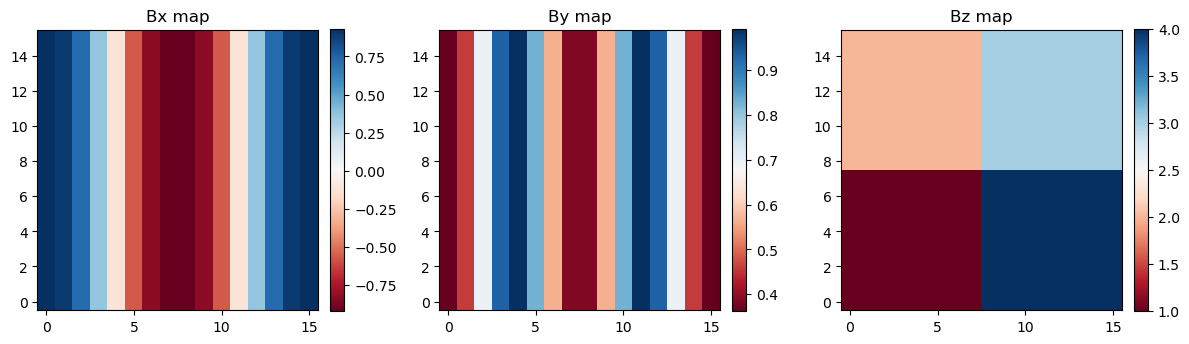

In [11]:
 # Diagnostics / plotting

fig, ax = plt.subplots(1, 3, figsize=(12,4))

im0 = ax[0].imshow(bxr, origin="lower", cmap="RdBu")
ax[0].set_title("Bx map")
plt.colorbar(im0, ax=ax[0],fraction=0.046, pad=0.04)

im1 = ax[1].imshow(byr, origin="lower", cmap="RdBu")
ax[1].set_title("By map")
plt.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)

im2 = ax[2].imshow(bzr, origin="lower", cmap="RdBu")
ax[2].set_title("Bz map")
plt.colorbar(im2, ax=ax[2],fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

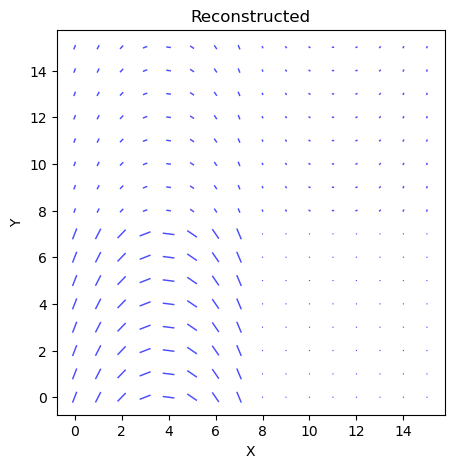

In [12]:
# rf.visual_UQ(iu,iq,label='Reconstructed',plotdex='xy')
rf.visual_UQ_depol(iu,iq,icos2g,label='Reconstructed',plotdex='ij')

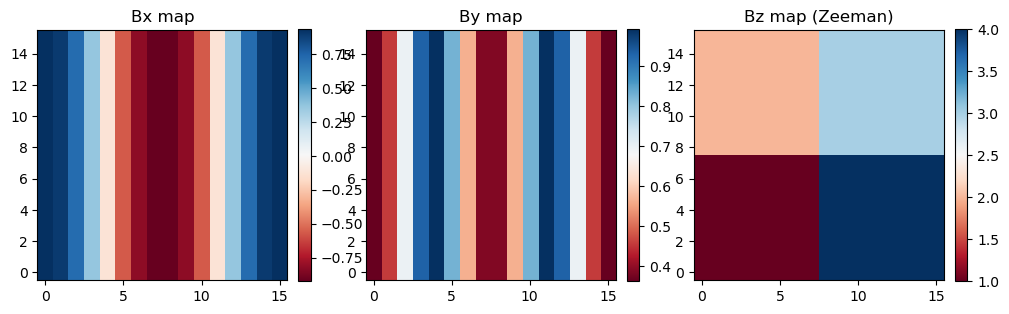

In [13]:

fig, ax = plt.subplots(1, 3, figsize=(12,4))

im0 = ax[0].imshow(Bx[:,:,0], origin="lower", cmap="RdBu")
ax[0].set_title("Bx map")
plt.colorbar(im0, ax=ax[0],fraction=0.046, pad=0.04)

im1 = ax[1].imshow(By[:,:,0], origin="lower", cmap="RdBu")
ax[1].set_title("By map")
plt.colorbar(im1, ax=ax[1],fraction=0.046, pad=0.04)

im2 = ax[2].imshow(Bz[:,:,0], origin="lower", cmap="RdBu")
ax[2].set_title("Bz map (Zeeman)")
plt.colorbar(im2, ax=ax[2],fraction=0.046, pad=0.04)

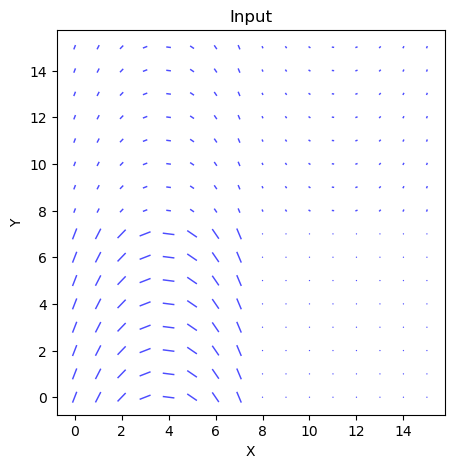

In [14]:
# rf.visual_UQ(U,Q,label='Input',plotdex='ij')
rf.visual_UQ_depol(U,Q,COS,label='Input',plotdex='ij')

In [15]:
residual = np.sqrt(np.mean((iu-U)**2 + (iq-Q)**2))
print(residual)

4.909389821274097e-17


## Extra

In [ ]:
# else:            
        #     u12 = u1_list.pop() # restricted 2d DATA; every time a level is used, remove
            
        #     b12 = rf.zeeman_recon_min_3D(u12) # reconstruct nxn square into nxnxn cube
            
        #     b32 = b3_list[-1] # grab previously prolonged cube
            
        #     print('[checkpoint]: B12 shape = ', np.shape(b12), 'B32 shape = ', np.shape(b32))

        #     if np.shape(b12) == np.shape(b32):
                # # set parameters for sampling
                # dtheta   = 0.4
                # dphi     = 0.3
                # R        = 12000
            #     # rbins    = R//150
            #     # ntrials  = 800
            #     # nbins    = ntrials//80
            #     # burn     = 500
            #     # plotting = 0

            #     # Check Level:
            #     if u12[0][0].shape[0] < C:  # still growing, still prolongating

            #         # b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
            #         #                           nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
            #         # print('[checkpoint]: Sampled B shape = ', np.shape(b22))

            #         # CHANGE THIS
            #         b33 = rf.prolong_3D(b22)

            #         print('[checkpoint]: ','B22 shape = ', np.shape(b22), 'B33 shape = ', np.shape(b33))

            #         J = b33[0][0].shape[0]

            #         b3_list.append(b33)

            #         p_vcycle(u1_list, b3_list, J, C)

            #     elif u12[0][0].shape[0] == C: # Hit last level. No more prolongation, but still want to sample 
            #         print(u12[0][0].shape[0])
            #         # Sample last level
            #         # b22 = sampler.mcmc_driver(data=b12, prolonged=b32, dtheta=dtheta, dphi=dphi, rbins=rbins, R=R, 
            #         #                           nbins=nbins, ntrials=ntrials, burn=burn, plotting=plotting)
                    
            #         b3_list.append(b22)

            #         print('Ceiling Hit at J = ', u12[0][0].shape[0])
            #         return
            #     else:
            #         print('You have gone past input dimensions, something is wrong.')
            # else:
            #     print('Reconstructed and Prolonged B field shapes do not match.')
